# Using the median for the plots

### Jan 28, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PCON0003/cond0068/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/Reco_sim/reco_code")
import deDisperse_util as util
from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
import pyrex.custom.ara as ara


Welcome to JupyROOT 6.18/04


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Events debugging

In [3]:
SNR_cutV = 0
SNR_cutH = 0
appended_data = []
import os
for filename in os.listdir("./"):#Loop over desired directory
        if (filename.startswith("polReco")): #extension, .root in this case
            name = os.path.join("./", str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)
recoNu = pd.concat(appended_data) 
# recoNu = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/debug/pol_quant_noiseless.pkl")
recoNu = recoNu.loc[abs(recoNu.maxV)>1]
recoNu = recoNu.loc[abs(recoNu.maxV)<1450]
recoNu = recoNu.loc[abs(recoNu.maxH)>1]
recoNu = recoNu.loc[abs(recoNu.maxH)<1450]
# recoNu = recoNu.loc[recoNu.theta_reco>=np.pi/2]
# recoNu = recoNu.loc[(recoNu.theta_reco>=np.radians(111)) & (recoNu.theta_reco<=np.radians(122))]

# recoNu = recoNu.loc[recoNu.weight>1E-100]
recoNu["SNR_V"] = abs(recoNu.maxV)/recoNu.rmsV
recoNu["SNR_H"] = abs(recoNu.maxH)/recoNu.rmsH
# recoNu = recoNu.loc[abs(recoNu.SNR_H-5)<1]
recoNu = recoNu.loc[(recoNu.SNR_H>=SNR_cutH) & (recoNu.SNR_V>=SNR_cutV)]
print(len(recoNu))
recoNu.batch = recoNu.batch.astype(int)

array2 = []
R_True = []
R_Reco = []
propVec = []
dot = []
omegafromAtan = []
for i in recoNu.itertuples(): 
    thetaHat = np.array([np.cos(i.theta_reco)*np.cos(i.phi_reco), np.cos(i.theta_reco)*np.sin(i.phi_reco), -np.sin(i.theta_reco)])
    phiHat = np.array([-np.sin(i.phi_reco), np.cos(i.phi_reco),0])
    if(i.powerH==0 or i.powerV==0):
        R_Reco.append(np.nan)
        R_True.append(np.nan)
        array2.append(np.nan)
        dot.append(np.nan)
        omegafromAtan.append(np.nan)

        continue
    R_Reco.append(np.sqrt(i.powerH/i.powerV))
#     R_Reco.append(abs(i.peak_H/i.peak_V))
    R = np.dot(i.PolTrue,phiHat)/(np.dot(i.PolTrue,thetaHat))
    R_True.append(R)
    PolReco = util.PolVectorRecoPower_sign(i.powerV,i.powerH, i.theta_reco, i.phi_reco,np.sign(R))
    array2.append(PolReco)
    omegafromAtan.append(np.degrees(np.arctan(np.sqrt(i.powerH/i.powerV))))
    propVec = np.array([np.sin(i.theta_reco)*np.cos(i.phi_reco),np.sin(i.theta_reco)*np.sin(i.phi_reco),np.cos(i.theta_reco)])
    dot.append(np.dot(i.PolTrue,PolReco))
recoNu["PolReco2"] = array2

recoNu["R_True"] = R_True
recoNu["R_Reco"] = R_Reco
recoNu["dotProd"] = dot
# recoNu = recoNu.loc[abs(recoNu.dotProd)<1E-2]
recoNu["omegafromAtan"] = omegafromAtan

recoNu = recoNu.dropna()


Px_true = np.array([element[0] for element in recoNu.PolTrue])
Py_true = np.array([element[1] for element in recoNu.PolTrue])
Pz_true = np.array([element[2] for element in recoNu.PolTrue])

Px_reco = np.array([element[0] for element in recoNu.PolReco2])
Py_reco = np.array([element[1] for element in recoNu.PolReco2])
Pz_reco = np.array([element[2] for element in recoNu.PolReco2])


thetaPol_true = np.degrees(np.arccos(abs(Pz_true)))
thetaPol_reco = np.degrees(np.arccos(abs(Pz_reco)))
phiPol_true = np.degrees(np.arctan2(abs(Py_true),abs(Px_true)))
phiPol_reco = np.degrees(np.arctan2(abs(Py_reco),abs(Px_reco)))


recoNu["delta"] = thetaPol_reco-thetaPol_true
recoNu["thetaPol_reco"] = thetaPol_reco
recoNu["thetaPol_true"] = thetaPol_true

recoNu["deltaPhi"] = phiPol_reco-phiPol_true
recoNu["phiPol_reco"] = phiPol_reco
recoNu["phiPol_true"] = phiPol_true

recoNu = recoNu.dropna()
# delta = delta[~np.isnan(delta)]


8527


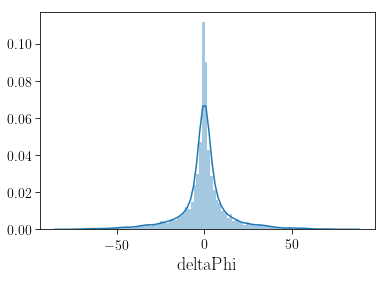

In [4]:
sns.distplot(recoNu.deltaPhi, bins = 100);

In [5]:
recoNu.deltaPhi.std()

14.948010458223596

## Stuff as a function of SNR

In [6]:
from scipy.optimize import curve_fit

# scipy.stats.norm.fit(delta)
def gauss(x,A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
bins=500


In [7]:
mean = [[],[],[]]
mean_err = [[],[]]
resolution = [[],[],[]]
resolution_err = [[],[],[]]
meanH = [[],[],[]]
meanH_err = [[],[]]
resolutionH = [[],[],[]]
resolutionH_err = [[],[],[]]
for SNR in np.arange(5,30,1):
    SNR_recoNu = recoNu.loc[abs(recoNu.SNR_V-SNR)<=1]

    delta = SNR_recoNu.delta
    deltaPhi = SNR_recoNu.deltaPhi
#     delta_mean = np.ma.average(delta,weights=SNR_recoNu.weight)
    delta_mean = np.median(delta)
    variance = np.dot(SNR_recoNu.weight, (delta - delta_mean) ** 2) / SNR_recoNu.weight.sum()
    delta_std = np.sqrt(variance)
    
    data_entries_Om, bins_Om = np.histogram(delta, bins=bins, weights=SNR_recoNu.weight, density=True)
    binscenters_Om = np.array([0.5 * (bins_Om[i] + bins_Om[i+1]) for i in range(len(bins_Om)-1)])
    poptOm, pcov = curve_fit(gauss, xdata=binscenters_Om, ydata=data_entries_Om)
    perr_Om = np.sqrt(np.diag(pcov))   
    mean_err[0].append(perr_Om[1])
    resolution_err[0].append(perr_Om[2])

    data_entries_Psi, bins_Psi = np.histogram(deltaPhi, bins=bins, weights=SNR_recoNu.weight, density=True)
    binscenters_Psi = np.array([0.5 * (bins_Psi[i] + bins_Psi[i+1]) for i in range(len(bins_Psi)-1)])
    poptPsi, pcov = curve_fit(gauss, xdata=binscenters_Psi, ydata=data_entries_Psi)
    perr_Psi = np.sqrt(np.diag(pcov))    
    mean_err[1].append(perr_Psi[1])
    resolution_err[1].append(perr_Psi[2])
    
    deltaPhi_mean = np.median(deltaPhi)
    variancePhi = np.dot(SNR_recoNu.weight, (deltaPhi - deltaPhi_mean) ** 2) / SNR_recoNu.weight.sum()
    deltaPhi_std = np.sqrt(variancePhi)
    
    resolution[0].append(SNR)
    resolution[1].append(delta.std())
    resolution[2].append(deltaPhi.std())
#     resolution[1].append(poptOm[2])
#     resolution[2].append(poptPsi[2])
    
    mean[0].append(SNR)
    mean[1].append(delta_mean)
    mean[2].append(deltaPhi_mean)
    
#     mean[1].append(poptOm[1])
#     mean[2].append(poptPsi[1])
    
for SNR in np.arange(5,30,1):
    SNR_recoNu = recoNu.loc[abs(recoNu.SNR_H-SNR)<=1]

    delta = SNR_recoNu.delta
    deltaPhi = SNR_recoNu.deltaPhi
    
    delta_mean = np.median(delta)
    variance = np.dot(SNR_recoNu.weight, (delta - delta_mean) ** 2) / SNR_recoNu.weight.sum()
    delta_std = np.sqrt(variance)
    
    deltaPhi_mean = np.median(deltaPhi)
    variancePhi = np.dot(SNR_recoNu.weight, (deltaPhi - deltaPhi_mean) ** 2) / SNR_recoNu.weight.sum()
    deltaPhi_std = np.sqrt(variancePhi)
    
    data_entries_Om, bins_Om = np.histogram(delta, bins=bins, weights=SNR_recoNu.weight, density=True)
    binscenters_Om = np.array([0.5 * (bins_Om[i] + bins_Om[i+1]) for i in range(len(bins_Om)-1)])
    poptOm, pcov = curve_fit(gauss, xdata=binscenters_Om, ydata=data_entries_Om)
    perr_Om = np.sqrt(np.diag(pcov))   
    meanH_err[0].append(perr_Om[1])
    resolutionH_err[0].append(perr_Om[2])
    
    data_entries_Psi, bins_Psi = np.histogram(deltaPhi, bins=bins, weights=SNR_recoNu.weight, density=True)
    binscenters_Psi = np.array([0.5 * (bins_Psi[i] + bins_Psi[i+1]) for i in range(len(bins_Psi)-1)])
    poptPsi, pcov = curve_fit(gauss, xdata=binscenters_Psi, ydata=data_entries_Psi)
    perr_Psi = np.sqrt(np.diag(pcov))    
    meanH_err[1].append(perr_Psi[1])
    resolutionH_err[1].append(perr_Psi[2])
    
    resolutionH[0].append(SNR)
    resolutionH[1].append(delta.std())
    resolutionH[2].append(deltaPhi.std())
#     resolutionH[1].append(poptOm[2])
#     resolutionH[2].append(poptPsi[2])
    
    meanH[0].append(SNR)
    meanH[1].append(delta_mean)
    meanH[2].append(deltaPhi_mean)
#     meanH[1].append(poptOm[1])
#     meanH[2].append(poptPsi[1])
    

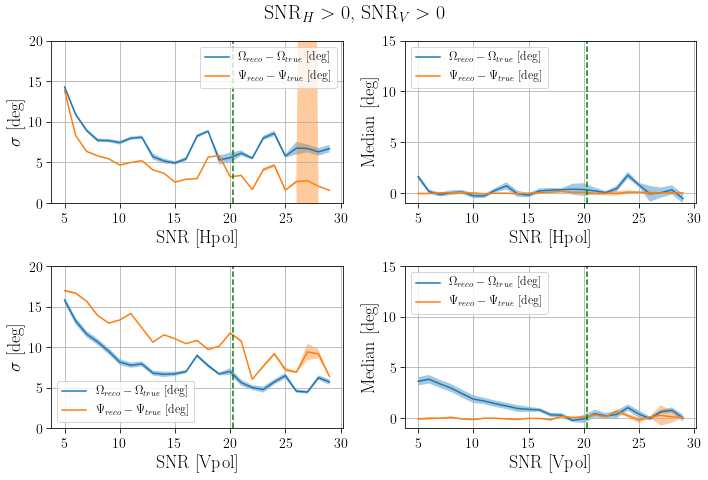

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
axes[0,0].plot(resolutionH[0],abs(np.array(resolutionH[1])), label="$\Omega_{reco}-\Omega_{true}$ [deg]")
axes[0,0].fill_between(resolutionH[0],resolutionH[1]+np.array(resolutionH_err[0]),resolutionH[1]-np.array(resolutionH_err[0]),alpha=0.4)
axes[0,0].plot(resolutionH[0],abs(np.array(resolutionH[2])), label="$\Psi_{reco}-\Psi_{true}$ [deg]")
axes[0,0].fill_between(resolutionH[0],abs(np.array(resolutionH[2]))+abs(np.array(resolutionH_err[1])),abs(np.array(resolutionH[2]))-abs(np.array(resolutionH_err[1])),alpha=0.4)
axes[0,0].set_xlabel("SNR [Hpol]")
axes[0,0].set_ylabel("$\sigma$ [deg]")
axes[0,0].axvline(20.3,ls="--",color="green")
axes[0,0].legend()
axes[0,0].grid()
axes[0,0].set_ylim(0,20)


axes[0,1].plot(meanH[0],meanH[1], label="$\Omega_{reco}-\Omega_{true}$ [deg]")
axes[0,1].fill_between(meanH[0],meanH[1]+np.array(meanH_err[0]),meanH[1]-np.array(meanH_err[0]),alpha=0.4)
axes[0,1].plot(meanH[0],meanH[2], label="$\Psi_{reco}-\Psi_{true}$ [deg]")
axes[0,1].fill_between(meanH[0],meanH[2]+np.array(meanH_err[1]),meanH[2]-np.array(meanH_err[1]),alpha=0.4)
axes[0,1].set_xlabel("SNR [Hpol]")
axes[0,1].set_ylabel("Median [deg]")
axes[0,1].axvline(20.3,ls="--",color="green")
axes[0,1].legend()
axes[0,1].grid()
axes[0,1].set_ylim(-1,15)


axes[1,0].plot(resolution[0],abs(np.array(resolution[1])), label="$\Omega_{reco}-\Omega_{true}$ [deg]")
axes[1,0].fill_between(resolution[0],abs(np.array(resolution[1]))+abs(np.array(resolution_err[0])),abs(np.array(resolution[1]))-abs(np.array(resolution_err[0])),alpha=0.4)
axes[1,0].plot(resolution[0],abs(np.array(resolution[2])), label="$\Psi_{reco}-\Psi_{true}$ [deg]")
# axes[1,0].fill_between(resolution[0],resolution[2]+np.array(resolution_err[1]),resolution[2]-np.array(resolution_err[1]),alpha=0.4)
axes[1,0].fill_between(resolution[0],abs(np.array(resolution[2]))+abs(np.array(resolution_err[1])),abs(np.array(resolution[2]))-abs(np.array(resolution_err[1])),alpha=0.4)

axes[1,0].set_xlabel("SNR [Vpol]")
axes[1,0].set_ylabel("$\sigma$ [deg]")
axes[1,0].axvline(20.3,ls="--",color="green")
axes[1,0].legend()
axes[1,0].grid()
axes[1,0].set_ylim(0,20)


axes[1,1].plot(mean[0],mean[1], label="$\Omega_{reco}-\Omega_{true}$ [deg]")
axes[1,1].fill_between(mean[0],mean[1]+np.array(mean_err[0]),mean[1]-np.array(mean_err[0]),alpha=0.4)
axes[1,1].plot(mean[0],mean[2], label="$\Psi_{reco}-\Psi_{true}$ [deg]")
axes[1,1].fill_between(mean[0],mean[2]+np.array(mean_err[1]),mean[2]-np.array(mean_err[1]),alpha=0.4)
axes[1,1].set_xlabel("SNR [Vpol]")
axes[1,1].set_ylabel("Median [deg]")
axes[1,1].axvline(20.3,ls="--",color="green")
axes[1,1].legend()
axes[1,1].grid()
axes[1,1].set_ylim(-1,15)
plt.suptitle("SNR$_H>%i$, SNR$_V>%i$"%(SNR_cutH,SNR_cutV), fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/PolReco_finalPlots/SNR_scan_ratioPowerWindowed_RecoSign_ARIANNA_SNR_limitedAng.png', dpi=250)

In [9]:
def find68PercentLimits(array, binNum, weights):
    upperLim = 0
    lowerLim = 0
    data_entries_Om, bins_Om = np.histogram(array, bins=binNum, weights=weights, density=True)
    bin_width = bins_Om[1] - bins_Om[0]
    binMedian = findMedianBin(array, binNum, weights)
#     print('binMedian is %i'%binMedian )
    for bins in range(binNum):
        integral = bin_width * sum(data_entries_Om[binMedian:bins])
        if (integral>0.34):
            break
        upperLim = bins
    for bins in range(binNum):
        integral = bin_width * sum(data_entries_Om[bins:binMedian])
        if (integral<0.34):
            break
        lowerLim = bins
    return bins_Om[binMedian], bins_Om[lowerLim], bins_Om[upperLim]

def findMedianBin(array, binNum, weights):
    data_entries_Om, bins_Om = np.histogram(array, bins=binNum, weights=weights, density=True)
    bin_width = bins_Om[1] - bins_Om[0]
    median = np.median(array)
    findBin = np.where(abs(bins_Om - median)<bin_width)
    return findBin[0][0]

## Same plot but with with 68% limits

In [10]:
SNR_arr = []

meanV = [[],[]]
upperV = [[],[]]
lowerV = [[],[]]

meanH = [[],[]]
upperH = [[],[]]
lowerH = [[],[]]

#Vpol

for SNR in np.arange(5,31,1):
    SNR_recoNu = recoNu.loc[abs(recoNu.SNR_V-SNR)<=1]
    SNR_arr.append(SNR)

    #Omega
    mean, lower, upper = find68PercentLimits(SNR_recoNu.delta, 500, SNR_recoNu.weight)
    meanV[0].append(mean)
    upperV[0].append(upper)
    lowerV[0].append(upper)
    
    #Psi
    mean, lower, upper = find68PercentLimits(SNR_recoNu.deltaPhi, 500, SNR_recoNu.weight)
    meanV[1].append(mean)
    upperV[1].append(upper)
    lowerV[1].append(upper)
    
#Hpol
for SNR in np.arange(5,31,1):
    SNR_recoNu = recoNu.loc[abs(recoNu.SNR_H-SNR)<=1]
    
    #Omega
    mean, lower, upper = find68PercentLimits(SNR_recoNu.delta, 500, SNR_recoNu.weight)
    meanH[0].append(mean)
    upperH[0].append(upper)
    lowerH[0].append(upper)
    
    #Psi
    mean, lower, upper = find68PercentLimits(SNR_recoNu.deltaPhi, 500, SNR_recoNu.weight)
    meanH[1].append(mean)
    upperH[1].append(upper)
    lowerH[1].append(upper)

SNR_arr = np.array(SNR_arr)

meanV = np.array(meanV)
upperV = np.array(upperV)
lowerV = np.array(lowerV)

meanH = np.array(meanH)
upperH = np.array(upperH)
lowerH = np.array(lowerH)

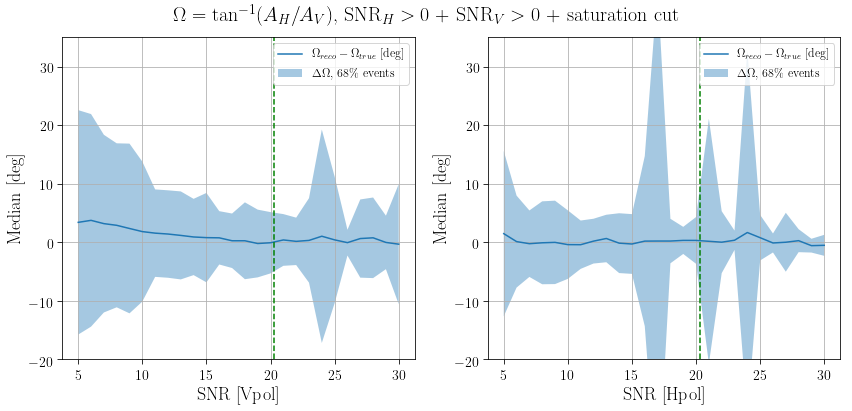

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(SNR_arr,meanV[0], label="$\Omega_{reco}-\Omega_{true}$ [deg]")
axes[0].fill_between(SNR_arr, meanV[0]-lowerV[0], meanV[0]+upperV[0] ,alpha=0.4, label = "$\Delta\Omega,\, 68\%$ events")

# axes[0].plot(SNR_arr,meanV[1], label="$\Psi_{reco}-\Psi_{true}$ [deg]")
# axes[0].fill_between(SNR_arr, meanV[1]-lowerV[1], meanV[1]+upperV[1] ,alpha=0.4, label = "$\Delta\Psi,\, 68\%$ events")

# axes[0,0].plot(resolutionH[0],abs(np.array(resolutionH[2])), label="$\Psi_{reco}-\Psi_{true}$ [deg]")
# axes[0,0].fill_between(resolutionH[0],abs(np.array(resolutionH[2]))+abs(np.array(resolutionH_err[1])),abs(np.array(resolutionH[2]))-abs(np.array(resolutionH_err[1])),alpha=0.4)
axes[0].set_xlabel("SNR [Vpol]")
axes[0].set_ylabel("Median [deg]")
axes[0].axvline(20.3,ls="--",color="green")
axes[0].legend(loc='upper right')
axes[0].grid()
axes[0].set_ylim(-20,35)


axes[1].plot(SNR_arr,meanH[0], label="$\Omega_{reco}-\Omega_{true}$ [deg]")
axes[1].fill_between(SNR_arr, meanH[0]-lowerH[0], meanH[0]+upperH[0] ,alpha=0.4, label = "$\Delta\Omega,\, 68\%$ events")

# axes[1].plot(SNR_arr,meanH[1], label="$\Psi_{reco}-\Psi_{true}$ [deg]")
# axes[1].fill_between(SNR_arr, meanH[1]-lowerH[1], meanH[1]+upperH[1] ,alpha=0.4, label = "$\Delta\Psi,\, 68\%$ events")

# axes[0,0].plot(resolutionH[0],abs(np.array(resolutionH[2])), label="$\Psi_{reco}-\Psi_{true}$ [deg]")
# axes[0,0].fill_between(resolutionH[0],abs(np.array(resolutionH[2]))+abs(np.array(resolutionH_err[1])),abs(np.array(resolutionH[2]))-abs(np.array(resolutionH_err[1])),alpha=0.4)
axes[1].set_xlabel("SNR [Hpol]")
axes[1].set_ylabel("Median [deg]")
axes[1].axvline(20.3,ls="--",color="green")
axes[1].legend(loc='upper right')
axes[1].grid()
axes[1].set_ylim(-20,35)

plt.suptitle("$\Omega = \\tan^{-1}({A_H/A_V})$, SNR$_H>%i$ + SNR$_V>%i$ + saturation cut"%(SNR_cutH,SNR_cutV), fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/PolReco_finalPlots/SNR_scan_forDave.png', dpi=250)

## Energy plots

In [13]:
SNR_arr = []

meanV = [[],[]]
upperV = [[],[]]
lowerV = [[],[]]

meanH = [[],[]]
upperH = [[],[]]
lowerH = [[],[]]

#Vpol

for energy in np.arange(17,21,0.5):
    SNR_recoNu = recoNu.loc[recoNu.energyArr==energy]
    SNR_arr.append(energy)

    #Omega
    mean, lower, upper = find68PercentLimits(SNR_recoNu.delta, 500, SNR_recoNu.weight)
    meanV[0].append(mean)
    upperV[0].append(upper)
    lowerV[0].append(upper)
    
    #Psi
    mean, lower, upper = find68PercentLimits(SNR_recoNu.deltaPhi, 500, SNR_recoNu.weight)
    meanV[1].append(mean)
    upperV[1].append(upper)
    lowerV[1].append(upper)
    
#Hpol
for energy in np.arange(17,21,0.5):
    SNR_recoNu = recoNu.loc[recoNu.energyArr==energy]
    
    #Omega
    mean, lower, upper = find68PercentLimits(SNR_recoNu.delta, 500, SNR_recoNu.weight)
    meanH[0].append(mean)
    upperH[0].append(upper)
    lowerH[0].append(upper)
    
    #Psi
    mean, lower, upper = find68PercentLimits(SNR_recoNu.deltaPhi, 500, SNR_recoNu.weight)
    meanH[1].append(mean)
    upperH[1].append(upper)
    lowerH[1].append(upper)

SNR_arr = np.array(SNR_arr)

meanV = np.array(meanV)
upperV = np.array(upperV)
lowerV = np.array(lowerV)

meanH = np.array(meanH)
upperH = np.array(upperH)
lowerH = np.array(lowerH)

IndexError: index 0 is out of bounds for axis 0 with size 0

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

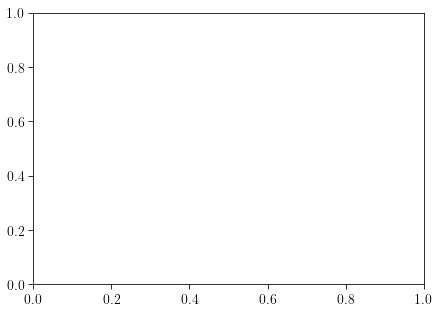

In [14]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.figure(figsize=(7,5))

plt.plot(SNR_arr,meanV[0], label="$\Omega_{reco}-\Omega_{true}$ [deg]")
plt.fill_between(SNR_arr, meanV[0]-lowerV[0], meanV[0]+upperV[0] ,alpha=0.4, label = "$\Delta\Omega,\, 68\%$ events")

plt.plot(SNR_arr,meanV[1], label="$\Psi_{reco}-\Psi_{true}$ [deg]")
plt.fill_between(SNR_arr, meanV[1]-lowerV[1], meanV[1]+upperV[1] ,alpha=0.4, label = "$\Delta\Psi,\, 68\%$ events")
plt.ylim(-20,35)
plt.xlabel("$\log_{10}{(E_{\\nu}}$/eV)")
plt.ylabel("Median [deg]")
plt.legend()
plt.grid()

plt.title("SNR$_H>%i$ + SNR$_V>%i$ + saturation cut"%(SNR_cutH,SNR_cutV))
plt.tight_layout()
# plt.savefig(my_path_plots+'/PolReco_finalPlots/EnergyVsResolution_Median_SNR_3and3.png', dpi=250)

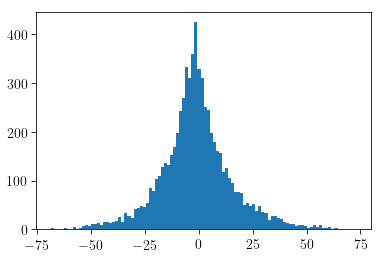

In [15]:
plt.hist(recoNu.omegafromAtan-recoNu.thetaPol_true, bins=100);

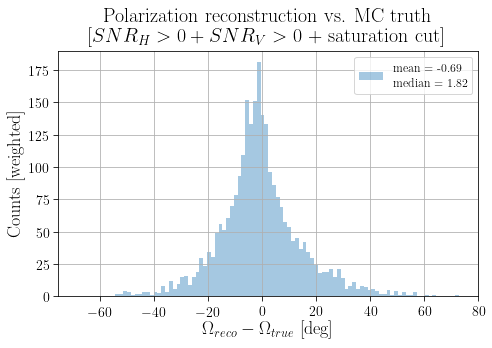

In [16]:
recoNu2 = recoNu.loc[(recoNu.SNR_H>=3) & (recoNu.SNR_V>=3)]
delta = recoNu2.omegafromAtan-recoNu2.thetaPol_true
plt.figure(figsize=(7,5))
delta_mean= np.ma.average(delta,weights=recoNu2.weight)
variance = np.dot(recoNu2.weight, (delta - delta_mean) ** 2) / recoNu2.weight.sum()
delta_std = np.sqrt(variance)

sns.distplot(delta, bins=100,hist_kws={'weights': recoNu2.weight},norm_hist=False,kde=False,label = "mean = %0.2f \n median = %0.2f"%(delta_mean, np.median(recoNu["delta"])));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\Omega_{reco}-\Omega_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [weighted]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Polarization reconstruction vs. MC truth \n [$SNR_{H}>%i + SNR_{V}>%i$ + saturation cut]"%(SNR_cutH,SNR_cutV))
# plt.xlim(-20,20)
# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/PolReco_finalPlots/deltaOmegaDistribution_SNR_%i.png'%SNR_cutV, dpi=250)
